In [65]:
import polars as pl

In [66]:
df = pl.read_csv("average_monthly_earnings_sex_occupation_annual.csv")

In [67]:
df.columns
df.head(3)

ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,time,obs_value,obs_status,obs_status.label,note_classif,note_classif.label,note_indicator,note_indicator.label,note_source,note_source.label
str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,str,str,str,str,str,str,str,str
"""ABW""","""Aruba""","""AA:22""","""PC - Population and Housing Ce…","""EAR_4MTH_SEX_OCU_CUR_NB""","""Average monthly earnings of em…","""SEX_T""","""Total""","""OCU_SKILL_TOTAL""","""Occupation (Skill level): Tota…","""CUR_TYPE_LCU""","""Currency: Local currency""",2010,3013.0,null,null,null,null,"""T11:142_T12:145_T33:396_T30:62""","""Job coverage: Main job current…","""S3:20""","""Data reference period: Septemb…"
"""ABW""","""Aruba""","""AA:22""","""PC - Population and Housing Ce…","""EAR_4MTH_SEX_OCU_CUR_NB""","""Average monthly earnings of em…","""SEX_T""","""Total""","""OCU_SKILL_TOTAL""","""Occupation (Skill level): Tota…","""CUR_TYPE_PPP""","""Currency: 2021 PPP $""",2010,1860.382,null,null,null,null,"""T11:142_T12:145_T33:396_T30:62""","""Job coverage: Main job current…","""S3:20""","""Data reference period: Septemb…"
"""ABW""","""Aruba""","""AA:22""","""PC - Population and Housing Ce…","""EAR_4MTH_SEX_OCU_CUR_NB""","""Average monthly earnings of em…","""SEX_T""","""Total""","""OCU_SKILL_TOTAL""","""Occupation (Skill level): Tota…","""CUR_TYPE_USD""","""Currency: U.S. dollars""",2010,1683.24,null,null,null,null,"""T11:142_T12:145_T33:396_T30:62""","""Job coverage: Main job current…","""S3:20""","""Data reference period: Septemb…"


In [68]:
print("Unique values in classif1:", df.select("classif1.label").unique())
print("Unique values in classif2:", df.select("classif2.label").unique())


Unique values in classif1: shape: (29, 1)
┌─────────────────────────────────┐
│ classif1.label                  │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ Occupation (ISCO-88): 1. Legis… │
│ Occupation (ISCO-08): Total     │
│ Occupation (ISCO-08): X. Not e… │
│ Occupation (Skill level): Skil… │
│ Occupation (ISCO-88): 9. Eleme… │
│ …                               │
│ Occupation (ISCO-88): X. Not e… │
│ Occupation (Skill level): Tota… │
│ Occupation (ISCO-08): 1. Manag… │
│ Occupation (Skill level): Skil… │
│ Occupation (ISCO-08): 3. Techn… │
└─────────────────────────────────┘
Unique values in classif2: shape: (3, 1)
┌──────────────────────────┐
│ classif2.label           │
│ ---                      │
│ str                      │
╞══════════════════════════╡
│ Currency: U.S. dollars   │
│ Currency: Local currency │
│ Currency: 2021 PPP $     │
└──────────────────────────┘


In [73]:
# Filter the dataframe to only rows where the currency is "PPP $"
df_ppp = df.filter(pl.col("classif2") == "CUR_TYPE_PPP")
# Filter rows where 'classif1.label' contains the words "Skill level"
df_ppp = df_ppp.filter(pl.col("classif1.label").str.contains("Skill level"))

# Group by ref_area and aggregate obs_value to get mean_earnings
df_ppp = (
    df_ppp
    .group_by(["ref_area", "ref_area.label", "time", "classif1", "classif1.label"], maintain_order=False)
    .agg(pl.col("obs_value").sum().alias("mean_earnings"))
    .sort(["classif1.label", "time"])
)





In [74]:
# Show the countries with the highest earnings in "Total" (all skill levels), accounting for null values

# Filter rows where classif1.label = "Total" (ignoring case) and exclude nulls in relevant columns
df_total = (
    df_ppp
    .filter(
        pl.col("classif1.label").is_not_null() & 
        pl.col("classif1.label").str.to_lowercase().str.contains("total") &
        pl.col("mean_earnings").is_not_null() &
        pl.col("ref_area").is_not_null() &
        pl.col("time").is_not_null()
    )
)

# For each country ("ref_area"), get the most recent year available (ignoring nulls for 'time')
most_recent_years = (
    df_total
    .group_by("ref_area")
    .agg(pl.col("time").max().alias("latest_time"))
)

# Join to get only the rows for each country's most recent year (removing nulls for the join keys)
df_total_latest = (
    df_total
    .join(most_recent_years, left_on=["ref_area", "time"], right_on=["ref_area", "latest_time"])
    .filter(pl.col("mean_earnings").is_not_null())
)

# Sort by mean_earnings descending and show the top 10, excluding any remaining null mean_earnings
df_richest = (
    df_total_latest
    .filter(pl.col("mean_earnings").is_not_null())
    .sort("mean_earnings", descending=True)
    .select(["ref_area", "ref_area.label", "time", "mean_earnings"])
)

print("Countries with the highest earnings in 'Total' (most recent year available):")
print(df_richest.head(10))


Countries with the highest earnings in 'Total' (most recent year available):
shape: (10, 4)
┌──────────┬──────────────────────────┬──────┬───────────────┐
│ ref_area ┆ ref_area.label           ┆ time ┆ mean_earnings │
│ ---      ┆ ---                      ┆ ---  ┆ ---           │
│ str      ┆ str                      ┆ i64  ┆ f64           │
╞══════════╪══════════════════════════╪══════╪═══════════════╡
│ ZWE      ┆ Zimbabwe                 ┆ 2023 ┆ 1.2744e7      │
│ PRI      ┆ Puerto Rico              ┆ 2020 ┆ 85729.657     │
│ LUX      ┆ Luxembourg               ┆ 2024 ┆ 26470.805     │
│ BEL      ┆ Belgium                  ┆ 2024 ┆ 24130.542     │
│ NLD      ┆ Netherlands              ┆ 2024 ┆ 20879.007     │
│ AUT      ┆ Austria                  ┆ 2024 ┆ 19496.658     │
│ FIN      ┆ Finland                  ┆ 2024 ┆ 17989.152     │
│ DEU      ┆ Germany                  ┆ 2022 ┆ 17973.217     │
│ USA      ┆ United States of America ┆ 2024 ┆ 17897.991     │
│ NOR      ┆ Norway       

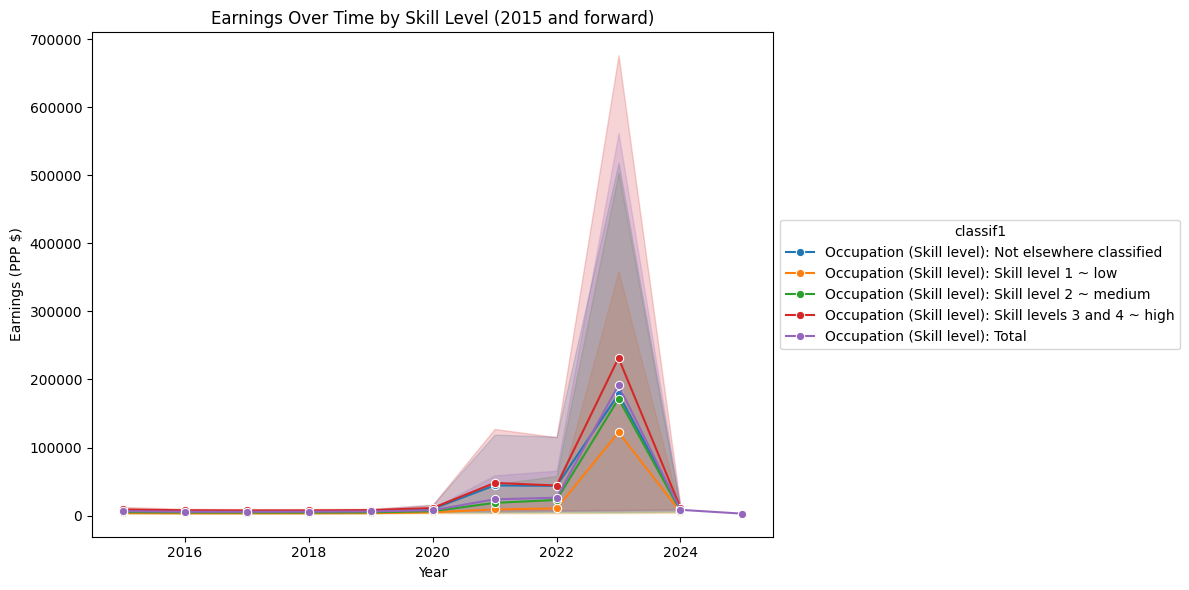

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data: ensure 'time' column is present for x-axis
# Assuming the year column is named 'time_period' or similar; adjust if needed.
# Also, ensure there are no missing values for plot clarity.
df_ppp_plot = df_ppp.drop_nulls(["time", "mean_earnings", "classif1.label"])

plt.figure(figsize=(12, 6))
# Filter to years 2015 and onward
plot_data = df_ppp_plot.filter(pl.col("time") >= 2015).to_pandas()
sns.lineplot(
    data=plot_data,
    x="time",
    y="mean_earnings",
    hue="classif1.label",
    marker="o"
)
plt.title("Earnings Over Time by Skill Level (2015 and forward)")
plt.xlabel("Year")
plt.ylabel("Earnings (PPP $)")
plt.legend(title='classif1', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
# Investigate the spike: check which countries/years have extreme values
df_spike_investigation = (
    df_ppp_plot
    .filter(pl.col("time") >= 2020)
    .sort("mean_earnings", descending=True)
    .select(["ref_area", "ref_area.label", "time", "classif1.label", "mean_earnings"])
)

print("Top 20 highest earnings values (2020-2024):")
print(df_spike_investigation.head(20))
print("\n")
print("Countries with earnings > 100,000 in 2022-2024:")
print(df_spike_investigation.filter(pl.col("mean_earnings") > 100000))


In [ ]:
# Create a graph that accounts for the spike by:
# 1. Excluding extreme outliers (e.g., values > 100,000 which are likely data errors)
# 2. Using median aggregation instead of sum to reduce impact of outliers
# 3. Showing both the raw data and the cleaned version

df_ppp_cleaned = (
    df_ppp
    .filter(pl.col("mean_earnings") < 100000)  # Exclude extreme outliers
    .drop_nulls(["time", "mean_earnings", "classif1.label"])
)

# Calculate median earnings over time by skill level (more robust to outliers)
df_ppp_median = (
    df_ppp_cleaned
    .group_by(["time", "classif1.label"])
    .agg(pl.col("mean_earnings").median().alias("median_earnings"))
    .sort(["classif1.label", "time"])
    .filter(pl.col("time") >= 2015)
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Original data with outliers
plot_data_original = df_ppp_plot.filter(pl.col("time") >= 2015).to_pandas()
sns.lineplot(
    data=plot_data_original,
    x="time",
    y="mean_earnings",
    hue="classif1.label",
    marker="o",
    ax=ax1
)
ax1.set_title("Earnings Over Time (Original - includes outliers)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Earnings (PPP $)")
ax1.legend(title='Skill Level', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

# Right plot: Cleaned data using median aggregation
plot_data_cleaned = df_ppp_median.to_pandas()
sns.lineplot(
    data=plot_data_cleaned,
    x="time",
    y="median_earnings",
    hue="classif1.label",
    marker="o",
    ax=ax2
)
ax2.set_title("Earnings Over Time (Cleaned - outliers removed, median aggregation)")
ax2.set_xlabel("Year")
ax2.set_ylabel("Median Earnings (PPP $)")
ax2.legend(title='Skill Level', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

plt.tight_layout()
plt.show()

print(f"Original data points: {len(plot_data_original)}")
print(f"Cleaned data points: {len(df_ppp_cleaned)}")
print(f"Outliers removed: {len(plot_data_original) - len(df_ppp_cleaned)}")
